# 📝 Projeto: Análise de Instâncias AWS - ICT Itaú

**Autor:** Lucas de Souza Lima  
**Descrição:** Este projeto realiza uma análise exploratória e preditiva dos dados de instâncias AWS, utilizando um pipeline de ingestão e processamento de dados, além de modelos de machine learning para prever custos e identificar padrões de uso.

---

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor  # Substituído por Regressor para prever custos
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [93]:
df = pd.read_csv("aws_dataset.csv")
df.head()

,instanceType,instanceFamily,instanceFamilyName,location,locationName,locationType,locationContinent,currentGeneration,supportedUsageClasses,supportedRootDeviceTypes,...,convertible1yAllUpfrontWindowsQuantity,convertible1yAllUpfrontWindowsMonth,convertible3yAllUpfrontLinuxQuantity,convertible3yAllUpfrontLinuxMonth,convertible3yAllUpfrontSuseQuantity,convertible3yAllUpfrontSuseMonth,convertible3yAllUpfrontRhelQuantity,convertible3yAllUpfrontRhelMonth,convertible3yAllUpfrontWindowsQuantity,convertible3yAllUpfrontWindowsMonth
0,t2.nano,t2,General purpose,ap-northeast-1,Asia Pacific (Tokyo),AWS Region,Asia Pacific,1,on-demand,ebs,...,68.0,5.67,103.0,2.86,103.0,2.86,NaN,NaN,163.0,4.53
1,t2.nano,t2,General purpose,ap-northeast-2,Asia Pacific (Seoul),AWS Region,Asia Pacific,1,on-demand,ebs,...,61.0,5.08,87.0,2.42,87.0,2.42,NaN,NaN,147.0,4.08
2,t2.nano,t2,General purpose,ap-northeast-3,Asia Pacific (Osaka),AWS Region,Asia Pacific,1,on-demand,ebs,...,68.0,5.67,103.0,2.86,103.0,2.86,NaN,NaN,163.0,4.53
3,t2.nano,t2,General purpose,ap-south-1,Asia Pacific (Mumbai),AWS Region,Asia Pacific,1,on-demand,ebs,...,56.0,4.67,72.0,2.00,72.0,2.00,NaN,NaN,132.0,3.67
4,t2.nano,t2,General purpose,ap-southeast-1,Asia Pacific (Singapore),AWS Region,Asia Pacific,1,on-demand,ebs,...,63.0,5.25,85.0,2.36,85.0,2.36,NaN,NaN,145.0,4.03


In [94]:
# =======================
# 2. Tratamento de dados
# =======================

# Separar variáveis categóricas e numéricas
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Preencher categóricas com moda
for col in cat_cols:
    moda = df[col].mode()[0]
    df[col] = df[col].fillna(moda)

# Preencher numéricas com mediana
for col in num_cols:
    mediana = df[col].median()
    df[col] = df[col].fillna(mediana)

# Exportar dataset tratado
df.to_csv("aws_pricing_tratado.csv", index=False)


In [95]:
# =======================
# Resumo Estatístico Selecionado
# =======================

cols_interessantes = [
    "vCpus", "vCpuCores", "vCpuThreadsPerCore", "memorySizeInGiB",
    "storageSupported", "storageTotalSizeInGB", "storageNvmeSupport",
    "maxNetworkInterfaces", "maxNetworkCards", "ipv4AddrPerInterface", "ipv6AddrPerInterface",
    "networkPerformance",
    "gpuCount", "gpuTotalGpuMemoryInGiB"
]

resumo = df[cols_interessantes].describe().T
print(resumo)

                          count         mean           std  min   25%   50%  \
vCpus                   17678.0    41.780575     54.589003  1.0   4.0  16.0   
vCpuCores               17678.0    26.248331     34.913224  1.0   4.0  16.0   
vCpuThreadsPerCore      17678.0     1.677339      0.467507  1.0   1.0   2.0   
memorySizeInGiB         17678.0   272.791715    783.435464  0.5  16.0  96.0   
storageSupported        17678.0     0.402874      0.490490  0.0   0.0   0.0   
storageTotalSizeInGB    17678.0  2469.360391  12517.347572  0.0   0.0   0.0   
maxNetworkInterfaces    17678.0     8.292001      5.667907  2.0   4.0   8.0   
maxNetworkCards         17678.0     1.055153      0.995470  1.0   1.0   1.0   
ipv4AddrPerInterface    17678.0    28.301392     15.874180  2.0  15.0  30.0   
ipv6AddrPerInterface    17678.0    28.195723     15.994290  0.0  15.0  30.0   
gpuCount                17678.0     0.120262      0.785191  0.0   0.0   0.0   
gpuTotalGpuMemoryInGiB  17678.0     4.167044     44.

## 📊 Resumo Estatístico Selecionado das Instâncias AWS

| Métrica | vCPUs | vCPU Cores | Threads/Core | Memória (GiB) | Armazenamento (GB) | ENIs Máx. | NICs Máx. | IPv4 / IF | IPv6 / IF | GPUs | Memória GPU (GiB) |
|---------|-------|------------|--------------|---------------|--------------------|-----------|-----------|-----------|-----------|------|-------------------|
| **count** | 17678 | 17678 | 17678 | 17678 | 17678 | 17678 | 17678 | 17678 | 17678 | 17678 | 17678 |
| **mean**  | 41.8 | 26.2 | 1.67 | 272.8 | 2469.4 | 8.3 | 1.05 | 28.3 | 28.2 | 0.12 | 4.17 |
| **std**   | 54.6 | 34.9 | 0.47 | 783.4 | 12517.3 | 5.7 | 0.99 | 15.9 | 16.0 | 0.79 | 44.7 |
| **min**   | 1   | 1   | 1 | 0.5 | 0 | 2 | 1 | 2 | 0 | 0 | 0 |
| **25%**   | 4   | 4   | 1 | 16  | 0 | 4 | 1 | 15 | 15 | 0 | 0 |
| **50%**   | 16  | 16  | 2 | 96  | 0 | 8 | 1 | 30 | 30 | 0 | 0 |
| **75%**   | 64  | 48  | 2 | 256 | 900 | 15 | 1 | 50 | 50 | 0 | 0 |
| **max**   | 896 | 448 | 2 | 32768 | 335520 | 80 | 32 | 50 | 50 | 8 | 1432 |

---

### 🔎 Insights Iniciais

- **CPU**: A maioria das instâncias possui entre **4 e 64 vCPUs**, mas existem instâncias muito grandes com até **896 vCPUs**.  
- **Memória**: A mediana é **96 GiB**, com instâncias chegando a **32 TiB** (voltadas para bancos de dados/machine learning).  
- **Armazenamento**: Mais da metade não tem armazenamento local (mediana = 0), mas algumas chegam a **335 TB**.  
- **Rede**: Normalmente entre **4 e 15 ENIs**, mas há instâncias que suportam até **80**.  
- **Endereços IP**: IPv4/IPv6 variam de 2 até 50 por interface de rede.  
- **GPU**: A esmagadora maioria **não possui GPU** (mediana = 0). Algumas instâncias especializadas oferecem até **8 GPUs** com **1.4 TB de memória de GPU** no total.  


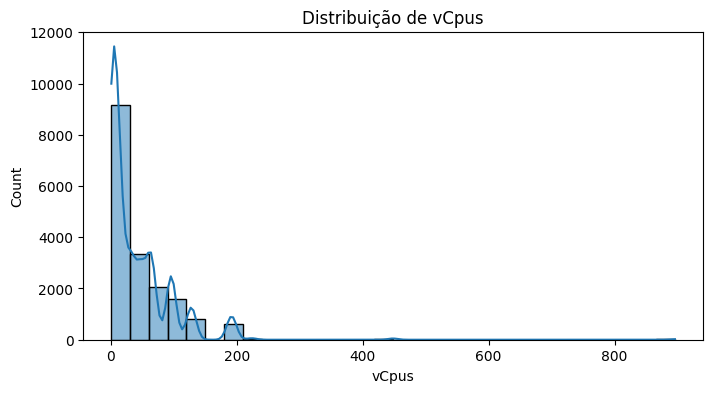

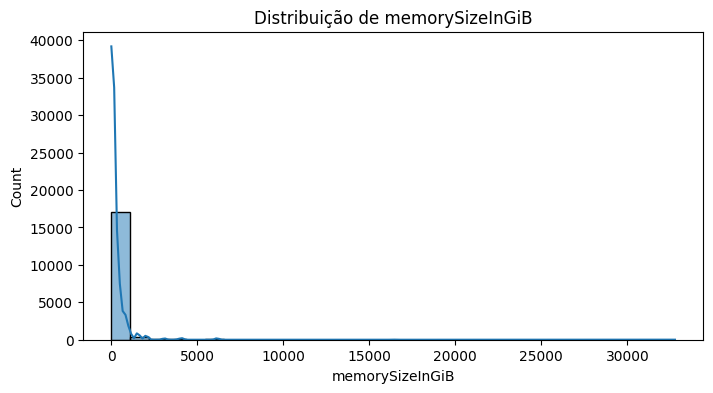

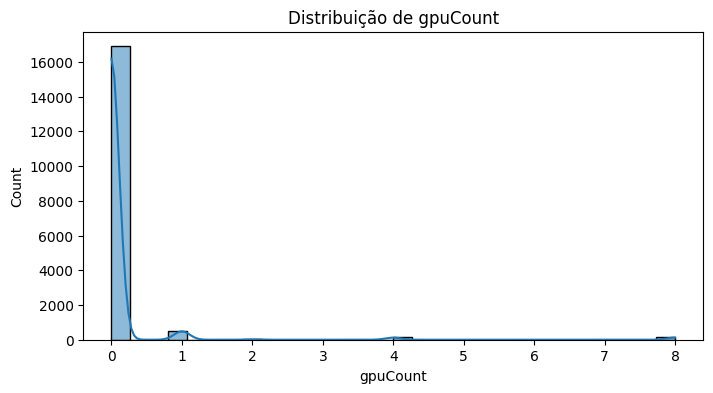

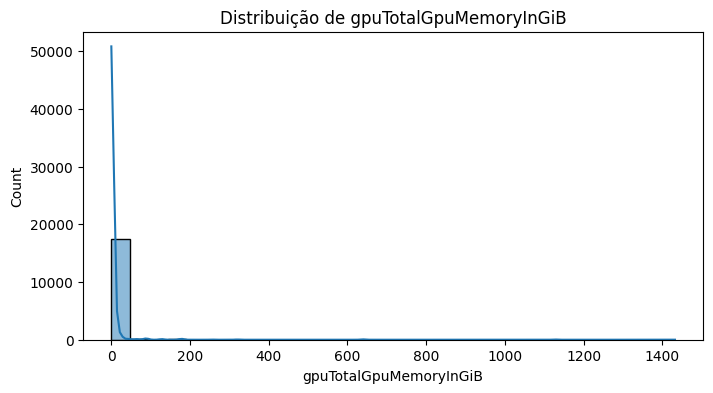

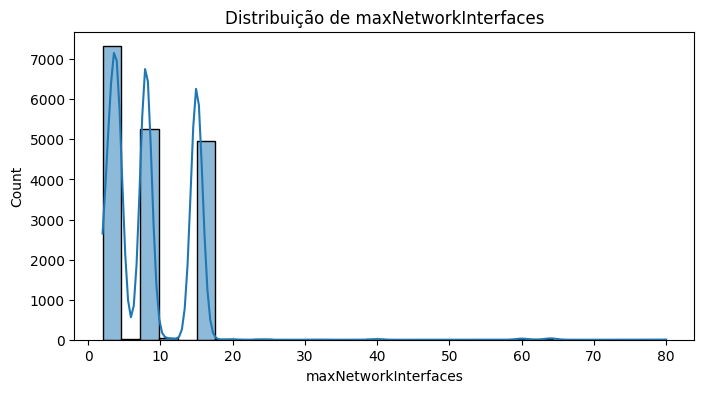

In [96]:
# Distribuição de algumas variáveis importantes
for col in ["vCpus", "memorySizeInGiB", "gpuCount", "gpuTotalGpuMemoryInGiB", "maxNetworkInterfaces"]:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Distribuição de {col}")
        plt.show()

📊 Análise Exploratória dos Recursos das Instâncias AWS
Nesta seção apresentamos uma análise descritiva dos principais recursos de hardware e rede disponíveis nas instâncias AWS.O objetivo é entender a distribuição de vCPUs, memória, GPUs e capacidades de rede, destacando tendências e possíveis implicações para workloads distintos.

🔢 vCPUs

A maior parte das instâncias possui poucos vCPUs, com uma concentração elevada em valores baixos (próximos a 0-100).  
Há uma cauda longa para valores mais altos, chegando a até 800 vCPUs em casos raros, indicando instâncias de alta performance.  
Isso reflete que a AWS oferece opções para workloads leves e cotidianos, mas também para computação intensiva como HPC e big data.

📌 Insight: vCPUs são escaláveis, mas a maioria das instâncias é otimizada para uso eficiente e custo moderado, não extremos.

🧠 Memória (memorySizeInGiB)

Grande concentração em valores baixos de memória (próximos a 0-5000 GiB), com contagens altas no início da distribuição.  
A cauda se estende para valores extremos acima de 30.000 GiB, mas com frequência muito baixa.  
Isso mostra que instâncias com alta memória são especializadas para aplicações como bancos de dados in-memory ou análise de dados massivos.

📌 Insight: A memória é um recurso variável e escalável, alinhado com necessidades de armazenamento temporário em workloads diversificados.

🎮 GPUs (gpuCount)

A esmagadora maioria das instâncias não possui GPU (valor 0 dominante).  
Quando presentes, o número de GPUs varia tipicamente de 1 a 4, com picos menores até 8, e raríssimos casos além disso.  
Isso indica que GPUs são recursos especializados, voltados para aplicações de Deep Learning, renderização e simulações científicas.

📌 Insight: O uso de GPU na AWS é restrito a instâncias específicas, não sendo o padrão, mas essencial para tarefas aceleradas por hardware.

💾 Memória Total de GPU (gpuTotalGpuMemoryInGiB)

Similar ao gpuCount, a maioria tem 0 GiB de memória GPU.  
Entre as instâncias com GPU, há picos em valores moderados (até ~200 GiB), com cauda para extremos acima de 1400 GiB.  
Isso destaca instâncias otimizadas para modelos de IA grandes ou processamento gráfico intensivo.

📌 Insight: A memória GPU é nichada e potente, suportando frameworks modernos de ML, mas disponível apenas em subconjuntos do portfólio AWS.

🌐 Interfaces de Rede Máximas (maxNetworkInterfaces)

Distribuição com picos distintos em valores baixos (2-15 interfaces), representando a maioria das instâncias.  
Há variações para valores mais altos (até ~80), com contagens menores, indicando suporte a rede avançada.  
Essa variação reflete opções para conectividade básica até alta escalabilidade em ambientes de nuvem.

📌 Insight: O suporte a múltiplas interfaces é um diferencial para alta disponibilidade, balanceamento de tráfego e workloads de rede intensivos.

✅ Conclusão Geral
A análise confirma que a maioria das instâncias AWS é básica (baixa contagem de vCPUs, memória moderada, sem GPU, rede simples), cobrindo workloads comuns como web hosting e desenvolvimento.Entretanto, existe um portfólio especializado para aplicações extremas, com foco em:

Computação de alto desempenho (instâncias com muitos vCPUs e memória)  
IA/Deep Learning (instâncias com GPUs e memória dedicada)  
Rede intensiva (instâncias com alta capacidade de interfaces)

👉 Em resumo, a AWS equilibra oferta massiva de instâncias padrão com opções de nicho para demandas específicas.

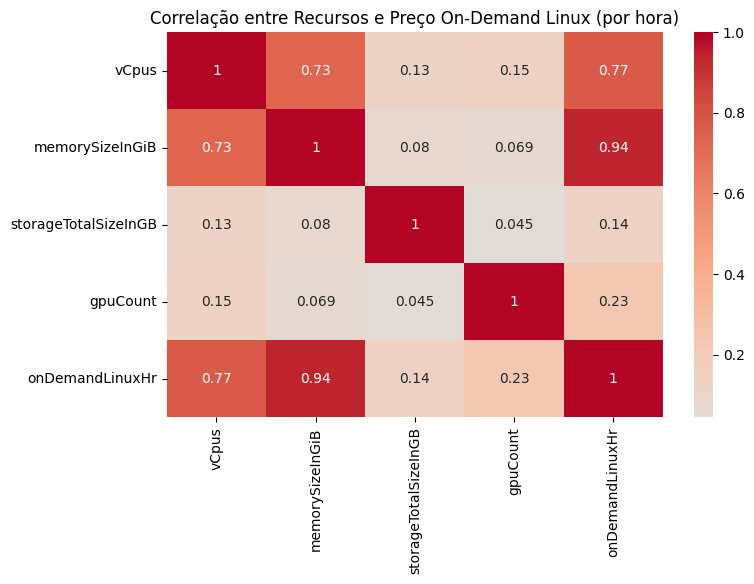

onDemandLinuxHr         1.000000
memorySizeInGiB         0.939732
vCpus                   0.769408
gpuCount                0.226103
storageTotalSizeInGB    0.143384
Name: onDemandLinuxHr, dtype: float64


In [97]:
# Seleciona só as colunas que fazem sentido + preço
cols = ["vCpus", "memorySizeInGiB", "storageTotalSizeInGB", "gpuCount", "onDemandLinuxHr"]
num_df = df[cols].dropna()

# Correlação
corr = num_df.corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlação entre Recursos e Preço On-Demand Linux (por hora)")
plt.show()

# Ranking de correlação com o preço
target = "onDemandLinuxHr"
print(corr[target].sort_values(ascending=False))

In [98]:
#print(df.columns.tolist())


🔗 Matriz de Correlação entre Recursos das Instâncias AWS e Preço On-Demand Linux
A análise de correlação mostra como os recursos de uma instância AWS influenciam diretamente o preço por hora. Isso ajuda a entender quais fatores mais impactam o custo e quais são relativamente independentes.

⚙️ vCPUs x Preço

Correlação forte e positiva (0.77).  
Faz sentido: instâncias com mais vCPUs têm custo maior por hora.

📌 Insight: O número de vCPUs é um dos principais drivers de preço.

🖥️ Memória RAM x Preço

Correlação muito forte e positiva (0.94).  
Mostra que a quantidade de memória é ainda mais determinante que CPU no custo da instância.

📌 Insight: Workloads de big data e machine learning, que exigem muita memória, aumentam substancialmente o custo.

💾 Armazenamento x Preço

Correlação muito fraca (0.14).  
Ou seja, o tamanho do disco não influencia diretamente o preço da instância on-demand.

📌 Insight: O custo de armazenamento é tratado separadamente (via EBS), e não como parte central do preço da instância.

🎮 GPUs x Preço

Correlação fraca (0.23).  
Embora GPUs sejam caras, o número de GPUs sozinho não explica fortemente o preço da instância.

📌 Insight: Instâncias GPU têm custo mais elevado, mas o impacto real depende do modelo e da família da instância, não apenas da quantidade.

✅ Conclusão
A matriz de correlação reforça três pontos principais:

CPU e memória são os maiores determinantes do preço — especialmente a memória.  
Armazenamento é quase independente do preço da instância, pois é tarifado à parte.  
GPUs têm impacto indireto — dependem da classe da instância, mas não são o fator principal no cálculo do preço por hora.

👉 Em resumo, o custo da instância on-demand Linux na AWS é estruturado principalmente em torno de CPU + memória, enquanto armazenamento e GPU são fatores secundários.